In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import scorecardpy as sc
import numpy as np
print(pd.__version__)

1.3.4


In [2]:
pip install pandas==1.3.4 --user

Note: you may need to restart the kernel to use updated packages.
  Using cached pandas-1.3.4-cp38-cp38-win_amd64.whl (10.2 MB)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yfinance 0.1.70 requires lxml>=4.5.1, which is not installed.
pandas-datareader 0.10.0 requires lxml, which is not installed.
investpy 1.0.8 requires lxml>=4.4.1, which is not installed.


In [4]:
pip install scorecardpy

  Using cached pandas-1.4.1-cp38-cp38-win_amd64.whl (10.6 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Accès refusé: 'D:\\anaconda3\\Lib\\site-packages\\pandas\\_libs\\algos.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



# Data Preprocessing

In [2]:
df = pd.read_csv("credit_data.csv",index_col=0)
#df=df.drop('Time',1)
df=df.drop('Checking account',1)
df.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_9596\4175484298.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df=df.drop('Checking account',1)


,Age,Sex,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,1169,6,radio/TV,good
1,22,female,2,own,little,5951,48,radio/TV,bad
2,49,male,1,own,little,2096,12,education,good
3,45,male,2,free,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,4870,24,car,bad


In [14]:
def missing_values_table(dataframe):
    variables_with_na = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[variables_with_na].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[variables_with_na].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df)
    return variables_with_na


missing_values_table(df)

                 n_miss  ratio
Saving accounts     183   18.3


['Saving accounts']

In [15]:
df["Saving accounts"].fillna(df['Saving accounts'].mode()[0], inplace=True)
#df["Checking account"].fillna(df['Checking account'].mode()[0], inplace=True)

In [16]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,little,1169,6,radio/TV,good
1,22,female,2,own,little,5951,48,radio/TV,bad
2,49,male,1,own,little,2096,12,education,good
3,45,male,2,free,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,4870,24,car,bad


In [17]:
df['Housing'].value_counts()

own     713
rent    179
free    108
Name: Housing, dtype: int64

In [18]:
dt_s = sc.var_filter(df, y="Risk")

[INFO] filtering variables ...


D:\anaconda3\lib\site-packages\scorecardpy\condition_fun.py:113: UserWarning: The positive value in "Risk" was replaced by 1 and negative value by 0.
  warnings.warn("The positive value in \"{}\" was replaced by 1 and negative value by 0.".format(y))


# Split data into independent variable X and target variable y

In [19]:
#X = df.loc[:,dt_s.columns != 'Risk']
#y = df.loc[:,dt_s.columns == 'Risk']

In [20]:
train, test = sc.split_df(df, 'Risk').values()

# Weight of Evidence

The weight of evidence tells the predictive power of an independent variable in relation to the dependent variable.

In [21]:
bins = sc.woebin(dt_s, y="Risk")

[INFO] creating woe binning ...


In [22]:
#bins

In [23]:
#sc.woebin_plot(bins)

In [24]:
train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(test, bins)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [25]:
y_train = train_woe.loc[:,'Risk']
X_train = train_woe.loc[:,train_woe.columns != 'Risk']
y_test = test_woe.loc[:,'Risk']
X_test = test_woe.loc[:,train_woe.columns != 'Risk']

In [27]:
# logistic regression model
from sklearn.linear_model import LogisticRegression
lr1 = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr1.fit(X_train, y_train)
print(lr1.coef_)
print(lr1.intercept_)

[[ 0.         -0.98794065 -0.56538065 -0.58962704 -0.28903493 -0.42746425
  -0.66333285 -0.69798781]]
[0.82254146]


In [28]:
y_pred=lr1.predict(X_test)

# scorecard

In [29]:
# scorecard
card = sc.scorecard(bins, lr1, X_train.columns)
# score
train_score = sc.scorecard_ply(train, card, only_total_score=False, print_step=0, replace_blank_na=True, var_kp = None)
test_score = sc.scorecard_ply(test, card, only_total_score=False, print_step=0, replace_blank_na=True, var_kp = None)
score = sc.scorecard_ply(df, card, only_total_score=False, print_step=0, replace_blank_na=True, var_kp = None)

D:\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [30]:
score

,Age_points,Purpose_points,Credit amount_points,Saving accounts_points,Sex_points,Housing_points,Duration_points,score
0,-15.0,-17.0,1.0,2.0,-3.0,-9.0,-66.0,221.0
1,38.0,-17.0,17.0,2.0,7.0,-9.0,57.0,423.0
2,-15.0,17.0,-11.0,2.0,-3.0,-9.0,-17.0,292.0
3,-15.0,3.0,17.0,2.0,-3.0,23.0,26.0,381.0
4,-15.0,3.0,17.0,2.0,-3.0,23.0,5.0,360.0
...,...,...,...,...,...,...,...,...
995,10.0,3.0,-31.0,2.0,7.0,-9.0,-17.0,293.0
996,-15.0,3.0,-11.0,2.0,-3.0,-9.0,5.0,300.0
997,-15.0,-17.0,1.0,2.0,-3.0,-9.0,-17.0,270.0
998,38.0,-17.0,-11.0,2.0,-3.0,23.0,57.0,417.0


In [31]:
score['score'].mean()

320.501

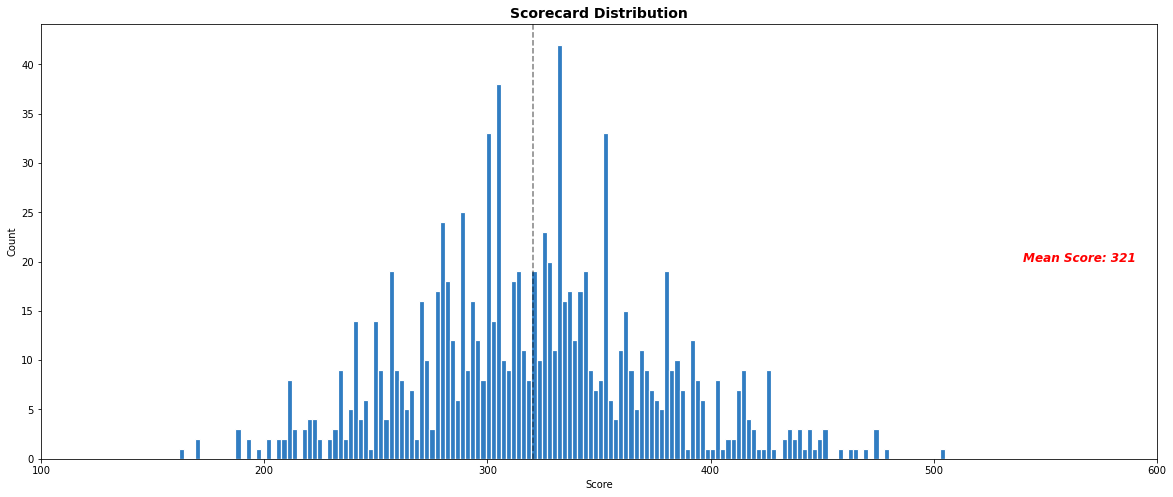

In [32]:
plt.figure(figsize=(20,8))

plt.hist(score['score'],
         bins=150,
         edgecolor='white',
         color = '#317DC2',
         linewidth=1.2)

plt.xlim(100,600)
plt.title('Scorecard Distribution', fontweight="bold", fontsize=14)
plt.axvline(score['score'].mean(), color='k', linestyle='dashed', linewidth=1.5, alpha=0.5)
plt.text(540, 20, 'Mean Score: 321', color='red', fontweight='bold', style='italic', fontsize=12)
plt.xlabel('Score')
plt.ylabel('Count');

In [33]:
import pickle
filename = 'finalized_model.pkl'
pickle.dump(lr1, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.7333333333333333


In [34]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.7333333333333333


# Score Prediction

In [122]:
# scorecard
card = sc.scorecard(bins, lr1, X_train.columns)
# score

score = sc.scorecard_ply(df, card, only_total_score=False, print_step=0, replace_blank_na=True, var_kp = None)

D:\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [123]:
df['score']=score['score']

In [124]:
df2=df.drop('Risk',1)

C:\Users\Admin\AppData\Local\Temp/ipykernel_13356/3040934892.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df2=df.drop('Risk',1)


In [125]:
df2

,Age,Sex,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,score
0,67,male,2,own,little,1169,6,radio/TV,231.0
1,22,female,2,own,little,5951,48,radio/TV,384.0
2,49,male,1,own,little,2096,12,education,310.0
3,45,male,2,free,little,7882,42,furniture/equipment,383.0
4,53,male,2,free,little,4870,24,car,363.0
...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,1736,12,furniture/equipment,304.0
996,40,male,3,own,little,3857,30,car,315.0
997,38,male,2,own,little,804,12,radio/TV,277.0
998,23,male,2,free,little,1845,45,radio/TV,367.0


In [128]:
df2["Saving accounts"][6] #quite rich
df2["Saving accounts"][8] #rich
df2.loc[df2['Saving accounts'] == 'rich' ]

,Age,Sex,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,score
8,61,male,1,own,rich,3059,12,radio/TV,248.0
27,42,female,2,rent,rich,409,12,radio/TV,307.0
30,36,male,2,own,rich,1913,18,business,303.0
67,22,male,2,own,rich,1007,12,car,282.0
94,54,male,2,own,rich,1318,12,car,282.0
136,27,male,2,own,rich,8613,27,car,315.0
140,27,male,0,own,rich,709,6,car,236.0
149,46,male,2,own,rich,1582,18,radio/TV,256.0
153,29,female,2,rent,rich,7758,24,car,365.0
167,20,female,2,own,rich,1577,11,furniture/equipment,284.0


In [129]:
df2.select_dtypes(['object']).columns

Index(['Sex', 'Housing', 'Saving accounts', 'Purpose'], dtype='object')

In [130]:
df2['Sex'] = df['Sex'].astype('category')
df2['Housing'] = df['Housing'].astype('category')
df2['Saving accounts'] = df['Saving accounts'].astype('category')
#df2['Checking account'] = df['Checking account'].astype('category')
df2['Purpose'] = df['Purpose'].astype('category')

In [131]:
cat_columns = df2.select_dtypes(['category']).columns
df2[cat_columns] = df2[cat_columns].apply(lambda x: x.cat.codes)

In [132]:
df2 = df2.astype(float)

In [133]:
df2

,Age,Sex,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,score
0,67.0,1.0,2.0,1.0,0.0,1169.0,6.0,5.0,231.0
1,22.0,0.0,2.0,1.0,0.0,5951.0,48.0,5.0,384.0
2,49.0,1.0,1.0,1.0,0.0,2096.0,12.0,3.0,310.0
3,45.0,1.0,2.0,0.0,0.0,7882.0,42.0,4.0,383.0
4,53.0,1.0,2.0,0.0,0.0,4870.0,24.0,1.0,363.0
...,...,...,...,...,...,...,...,...,...
995,31.0,0.0,1.0,1.0,0.0,1736.0,12.0,4.0,304.0
996,40.0,1.0,3.0,1.0,0.0,3857.0,30.0,1.0,315.0
997,38.0,1.0,2.0,1.0,0.0,804.0,12.0,5.0,277.0
998,23.0,1.0,2.0,0.0,0.0,1845.0,45.0,5.0,367.0


In [135]:
df2["Saving accounts"][8] #rich

3.0

In [116]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df2, test_size=0.2)

In [117]:
Y_train = pd.DataFrame()
Y_test = pd.DataFrame()
Y_train["score"] = train["score"]
Y_test["score"] = test["score"]
X_train = train.drop('score', 1)
X_test = test.drop('score', 1)

C:\Users\Admin\AppData\Local\Temp/ipykernel_13356/3167819368.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train = train.drop('score', 1)
C:\Users\Admin\AppData\Local\Temp/ipykernel_13356/3167819368.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test = test.drop('score', 1)


# LOGISTIC REGRESSION

In [500]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l1', C=0.9, solver='liblinear', n_jobs=-1)
#lr = LinearRegression()
#lr =LogisticRegression(random_state=0, class_weight= "balanced")
lr.fit(X_train, Y_train)

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


LogisticRegression(C=0.9, n_jobs=-1, penalty='l1', solver='liblinear')

In [501]:
Y_pred = lr.predict(X_test)
Y_pred

array([250., 305., 296., 392., 375., 229., 305., 327., 351., 296., 296.,
       311., 311., 392., 305., 296., 281., 287., 281., 305., 296., 375.,
       375., 296., 296., 268., 250., 296., 296., 320., 311., 305., 287.,
       305., 306., 296., 305., 296., 296., 296., 347., 268., 375., 327.,
       375., 305., 375., 311., 305., 305., 336., 311., 320., 300., 296.,
       287., 375., 296., 373., 296., 281., 302., 296., 296., 375., 290.,
       375., 305., 302., 320., 273., 259., 305., 300., 287., 287., 291.,
       305., 296., 414., 351., 289., 320., 336., 305., 375., 377., 236.,
       287., 311., 287., 375., 296., 311., 336., 377., 296., 416., 287.,
       296., 305., 305., 327., 281., 296., 377., 305., 393., 311., 377.,
       305., 312., 326., 351., 305., 375., 311., 336., 342., 390., 311.,
       287., 305., 375., 287., 244., 336., 377., 375., 296., 293., 351.,
       336., 377., 268., 336., 312., 263., 375., 296., 273., 314., 305.,
       296., 358., 375., 311., 296., 375., 259., 28

In [502]:
from sklearn.metrics import mean_squared_error
# root mean square error
rms = mean_squared_error(Y_test, Y_pred, squared=False)
rms

34.00066175826583

In [503]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test,Y_pred)

0.14

In [504]:
score = lr.score(X_test, Y_test)
print(score)

0.14


# RandomForest

In [427]:
from sklearn.ensemble import RandomForestClassifier

In [451]:
forest = RandomForestClassifier(max_depth=2, random_state=0)
forest.fit(X_train, Y_train)

ValueError: could not convert string to float: 'female'

In [429]:
pred_forest = forest.predict(X_test)

In [430]:
accuracy_score(Y_test,pred_forest)

0.01

# SVM

In [408]:
from sklearn import svm

svm = svm.SVC(gamma='auto',class_weight="balanced")
svm.fit(X_train, Y_train)

D:\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(class_weight='balanced', gamma='auto')

In [415]:
pred_svm = svm.predict(X_test)
pred_svm 

array([300., 388., 388., 300., 388., 388., 388., 300., 388., 359., 359.,
       300., 388., 359., 359., 388., 300., 388., 388., 388., 359., 388.,
       388., 359., 388., 388., 300., 359., 388., 388., 388., 300., 388.,
       359., 388., 359., 359., 300., 388., 300., 359., 388., 388., 388.,
       388., 388., 388., 300., 300., 359., 388., 388., 359., 300., 300.,
       388., 300., 359., 388., 388., 388., 388., 300., 388., 388., 388.,
       388., 388., 300., 300., 388., 388., 388., 300., 388., 388., 388.,
       388., 388., 388., 388., 388., 388., 388., 388., 388., 388., 300.,
       300., 388., 388., 300., 359., 300., 300., 300., 300., 388., 388.,
       359., 388., 359., 388., 388., 388., 359., 300., 388., 388., 300.,
       388., 359., 388., 300., 388., 388., 388., 300., 388., 388., 388.,
       388., 388., 359., 388., 300., 388., 300., 300., 359., 359., 388.,
       388., 388., 388., 388., 359., 388., 388., 300., 388., 388., 359.,
       388., 388., 388., 300., 388., 359., 300., 38

In [414]:
accuracy_score(Y_test, pred_svm)

0.005

# Decision Tree


In [432]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=0)

In [436]:
y_pred = clf.predict(X_test)
print('accuracy score: ',accuracy_score(Y_test,y_pred))

accuracy score:  0.195


# KNN

In [437]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train, Y_train)

D:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=10)

In [439]:
preKnn = neigh.predict(X_test)

In [440]:
accuracy_score(Y_test, preKnn)

0.015

# LinearRegression

In [560]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, Y_train)

LinearRegression()

In [561]:
from sklearn.metrics import mean_squared_error
# root mean square error
rms = mean_squared_error(Y_test, Y_pred, squared=False)
rms

64.97337916408534

In [562]:
score = lr.score(X_test, Y_test)
print(score)

0.5984398521986395


In [563]:
df_pred = X_test.copy()
df_pred["real_score"] = Y_test
df_pred["predicted_score"] = Y_pred

In [564]:
df_pred


,Age,Sex,Job,Housing,Saving accounts,Credit amount,Duration,Purpose,real_score,predicted_score
761,24.0,0.0,2.0,2.0,0.0,2124.0,18.0,4.0,391.0,250.0
341,26.0,0.0,1.0,2.0,0.0,3599.0,21.0,4.0,342.0,305.0
353,28.0,1.0,2.0,2.0,0.0,6199.0,12.0,5.0,339.0,296.0
224,30.0,1.0,2.0,1.0,0.0,4657.0,15.0,1.0,331.0,392.0
975,57.0,0.0,1.0,1.0,2.0,1258.0,24.0,5.0,282.0,375.0
...,...,...,...,...,...,...,...,...,...,...
717,32.0,1.0,3.0,0.0,0.0,1505.0,18.0,5.0,317.0,311.0
228,22.0,1.0,2.0,1.0,0.0,1478.0,9.0,5.0,291.0,287.0
516,40.0,1.0,1.0,1.0,0.0,1361.0,6.0,1.0,241.0,373.0
181,30.0,1.0,3.0,1.0,0.0,4455.0,36.0,0.0,381.0,336.0


## Save and load the model

In [565]:
import pickle
filename = 'finalized_model_score.pkl'
pickle.dump(lr, open(filename, 'wb'))

loaded_model1 = pickle.load(open(filename, 'rb'))
result = loaded_model1.predict(X_test)

In [566]:
df3=pd.DataFrame()

In [567]:
df3["Age"]=[50.0]
df3["Sex"]=[0.0]
df3["Job"]=[1.0]
df3["Housing"]=[2.0]
df3["Saving accounts"]=[3.0]
#df3["Checking account"]=[3.0]
df3["Credit amount"]=[1500.0]
df3["Duration"]=[10.0]
df3["Purpose"]=[2.0]

In [568]:
df3

,Age,Sex,Job,Housing,Saving accounts,Credit amount,Duration,Purpose
0,50.0,0.0,1.0,2.0,3.0,1500.0,10.0,2.0


In [569]:
result3 =loaded_model1.predict(df3)

In [570]:
print(result3)

[[267.59500209]]


In [571]:
result3[0][0]

267.5950020940936

In [516]:
pip install Flask